In [130]:
%pip install kagglehub kaggle torch numpy scikit-learn pandas matplotlib --quiet


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [132]:
from sklearn.model_selection import train_test_split
from pathlib import Path
from collections import Counter
import numpy as np
import kagglehub
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Where kagglehub unpacked
root = Path(kagglehub.dataset_download("yianqaq/adfa-ld"))

# The “master” folder of the original release
base = root / "ADFA-LD"
train_dir  = base / "Training_Data_Master"
val_dir    = base / "Validation_Data_Master"
attack_dir = base / "Attack_Data_Master"


# Gather paths and labels
normals = list(train_dir.glob("*.txt")) + list(val_dir.glob("*.txt"))
attacks = list(attack_dir.rglob("*.txt"))

all_paths  = normals + attacks
all_labels = [0]*len(normals) + [1]*len(attacks)

# First split: carve off TEST (20%)
trainval_paths, test_paths, trainval_labels, test_labels = train_test_split(
    all_paths, all_labels,
    test_size=0.20,
    stratify=all_labels,
    random_state=42
)

# Second split: from remaining 80%, carve off VAL (20% of that → 16% of total)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    trainval_paths, trainval_labels,
    test_size=0.20,
    stratify=trainval_labels,
    random_state=42
)

def load_syscall_sequence(path):
    text = path.read_text().strip()
    return list(map(int, text.split()))

def load_all_sequences(paths):
    return [load_syscall_sequence(p) for p in paths]

# Create a vocabulary of syscalls from 0 to N where N is the number of unique syscalls seen in the training set.
cnt = Counter()
train_seqs = load_all_sequences(train_paths)
val_seqs   = load_all_sequences(val_paths)
test_seqs  = load_all_sequences(test_paths)

for seq in train_seqs:
    cnt.update(seq)

syscall2idx = {sys: i for i, (sys, _) in enumerate(cnt.most_common())}
print(f"Number of unique syscalls in training: {len(syscall2idx)}")
unknown_idx = len(syscall2idx)    # last index for “any other” syscalls
vocab_size   = len(syscall2idx) 

Number of unique syscalls in training: 174


# create histograms for every sample

In [62]:
def extract_histogram(sequence, syscall2idx):
    # Create a histogram of syscall occurrences in the sequence
    # unknown_idx is used for syscalls not seen in the training set
    hist = np.zeros(len(syscall2idx) + 1, dtype=np.float32)
    for syscall in sequence:
        idx = syscall2idx.get(syscall, unknown_idx)
        hist[idx] += 1
    return hist

def build_histogram_features(sequences, syscall2idx):
    return np.array([extract_histogram(seq, syscall2idx) for seq in sequences])

Xh_train = build_histogram_features(train_seqs, syscall2idx)
Xh_val   = build_histogram_features(val_seqs, syscall2idx)
Xh_test  = build_histogram_features(test_seqs, syscall2idx)

y_train = np.array(train_labels)
y_val   = np.array(val_labels)
y_test  = np.array(test_labels)

print("▸ X_train shape:", Xh_train.shape)
print("▸ X_val shape:", Xh_val.shape)
print("▸ X_test shape:", Xh_test.shape)

▸ X_train shape: (3808, 175)
▸ X_val shape: (952, 175)
▸ X_test shape: (1191, 175)


# Create 3grams

In [ ]:
# Count all 3-grams in the TRAIN set
def count_3grams(seqs):
    ctr = Counter()
    for seq in seqs:
        for i in range(len(seq) - 2):
            trigram = (seq[i], seq[i+1], seq[i+2])
            ctr[trigram] += 1
    return ctr

threegram_counter = count_3grams(train_seqs)

# Keep only the top-k most common 3-grams
k = 500
top_k_3grams = [threeg for threeg, _ in threegram_counter.most_common(k)]

# Build a mapping from trigram → column index
threegram2idx = {threeg: i for i, threeg in enumerate(top_k_3grams)}
print(f"Using top {len(threegram2idx)} 3-grams as features.")

# Function to extract a k-dimensional count vector from a single sequence
# addes to each of the 3-grams bin if it appears in the sequence
# If a trigram is not in the mapping, it is ignored.
def extract_3gram_features(seq, threegram2idx):
    vec = np.zeros(len(threegram2idx), dtype=np.float32)
    for i in range(len(seq) - 2):
        tg = (seq[i], seq[i+1], seq[i+2])
        idx = threegram2idx.get(tg)
        if idx is not None:
            vec[idx] += 1
    return vec

# Build full 3-gram feature matrices
X3_train = np.array([extract_3gram_features(seq, threegram2idx) for seq in train_seqs])
X3_val   = np.array([extract_3gram_features(seq, threegram2idx) for seq in val_seqs])
X3_test  = np.array([extract_3gram_features(seq, threegram2idx) for seq in test_seqs])

print("▸ X3_train shape:", X3_train.shape)  # expected (n_train, 500)
print("▸ X3_val   shape:", X3_val.shape)
print("▸ X3_test  shape:", X3_test.shape)


Using top 500 3-grams as features.
▸ X3_train shape: (3808, 500)
▸ X3_val   shape: (952, 500)
▸ X3_test  shape: (1191, 500)


# extracting statistical features

In [60]:
# getting the total sequance length
def extract_length_feature(seqs):
    """
    Given a list of syscall sequences, return a (n_samples, 1) array
    of their lengths.
    """
    lengths = [len(seq) for seq in seqs]
    return np.array(lengths, dtype=np.float32).reshape(-1, 1)

# Build the length feature for each split
Xlen_train = extract_length_feature(train_seqs)
Xlen_val   = extract_length_feature(val_seqs)
Xlen_test  = extract_length_feature(test_seqs)

print("Length feature shapes:",
      Xlen_train.shape, Xlen_val.shape, Xlen_test.shape)

#getting the number of unique syscalls in each sequence

def extract_unique_count_feature(seqs):
    """
    Given a list of syscall sequences, return a (n_samples, 1) array
    of the count of unique syscalls in each sequence.
    """
    uniques = [len(set(seq)) for seq in seqs]
    return np.array(uniques, dtype=np.float32).reshape(-1, 1)

# Build the unique-count feature for each split
Xuniq_train = extract_unique_count_feature(train_seqs)
Xuniq_val   = extract_unique_count_feature(val_seqs)
Xuniq_test  = extract_unique_count_feature(test_seqs)

print("Unique-count feature shapes:",
      Xuniq_train.shape, Xuniq_val.shape, Xuniq_test.shape)

# getting the enropy of each sequence
def extract_entropy_feature(seqs):
    """
    Compute Shannon entropy (in bits) for each syscall sequence.
    Args:
      seqs (List[List[int]]): List of sequences, each a list of syscall IDs.
    Returns:
      np.ndarray of shape (n_samples, 1): The entropy of each sequence.
    """
    entropies = []
    for seq in seqs:
        length = len(seq)
        if length == 0:
            entropies.append(0.0)
            continue
        # Count how many times each syscall appears
        _, counts = np.unique(seq, return_counts=True)
        # Convert counts to probabilities
        freqs = counts / counts.sum()
        # Compute H = -sum(p_i * log2(p_i))
        ent = -np.sum(freqs * np.log2(freqs))
        entropies.append(ent)
    # Return as a (n_samples, 1) column vector
    return np.array(entropies, dtype=np.float32).reshape(-1, 1)

# Build the entropy feature for each split
Xent_train = extract_entropy_feature(train_seqs)
Xent_val   = extract_entropy_feature(val_seqs)
Xent_test  = extract_entropy_feature(test_seqs)

print("Entropy feature shapes:",
      Xent_train.shape, Xent_val.shape, Xent_test.shape)

#senity check!
# Find zero‐entropy samples
zero_ent_idx = np.where(Xent_train.flatten() == 0.0)[0]

# 1) How many such samples?
print("Zero‐entropy samples count:", len(zero_ent_idx))

# 2) What are the first five indices?
print("First five zero‐entropy indices:", zero_ent_idx[:5])

# 3) Label breakdown
labels_zero = y_train[zero_ent_idx]
counts = np.bincount(labels_zero, minlength=2)
print(f"  • Zero‐entropy normals: {counts[0]}")
print(f"  • Zero‐entropy attacks: {counts[1]}")

# 4) Inspect the first zero‐entropy sample
first_idx = zero_ent_idx[0]
print(f"Sample #{first_idx} first 5 syscalls:", train_seqs[first_idx][:5])
print(f"Sample #{first_idx} is labeled:", 
      "attack" if y_train[first_idx] == 1 else "normal")

Length feature shapes: (3808, 1) (952, 1) (1191, 1)
Unique-count feature shapes: (3808, 1) (952, 1) (1191, 1)
Entropy feature shapes: (3808, 1) (952, 1) (1191, 1)
Zero‐entropy samples count: 31
First five zero‐entropy indices: [ 14  16  93 382 464]
  • Zero‐entropy normals: 29
  • Zero‐entropy attacks: 2
Sample #14 first 5 syscalls: [162, 162, 162, 162, 162]
Sample #14 is labeled: normal


# combine the feature to create our vector

In [ ]:
#  [ histogram | 3-gram counts | length | unique-count | entropy ]= [175 + 500 + 1 +1 +1 ]
X_train_full = np.hstack([Xh_train, X3_train, Xlen_train, Xuniq_train, Xent_train])
X_val_full   = np.hstack([Xh_val,   X3_val,   Xlen_val,   Xuniq_val,   Xent_val])
X_test_full  = np.hstack([Xh_test,  X3_test,  Xlen_test,  Xuniq_test,  Xent_test])

print("Full train shape:", X_train_full.shape)
print("Full val   shape:", X_val_full.shape)

Full train shape: (3808, 678)
Full val   shape: (952, 678)


# model definition

In [111]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced',
    #random state is set for reproducibility
    random_state=42
)

# Training!

In [112]:


# 2) Fit on the full training matrix
rf.fit(X_train_full, y_train)

# 3) Predict on validation
y_val_pred = rf.predict(X_val_full)

print("Validation accuracy:", rf.score(X_val_full, y_val))

Validation accuracy: 0.9821428571428571


# Test!

In [113]:
#predict on test set
y_test_pred = rf.predict(X_test_full)
print("Test accuracy:    ", rf.score(X_test_full, y_test))
print("Test classification report:\n", classification_report(y_test, y_test_pred, digits=4))
print("Test confusion matrix:\n", confusion_matrix(y_test, y_test_pred))

Test accuracy:     0.9739714525608733
Test classification report:
               precision    recall  f1-score   support

           0     0.9773    0.9933    0.9852      1042
           1     0.9470    0.8389    0.8897       149

    accuracy                         0.9740      1191
   macro avg     0.9622    0.9161    0.9375      1191
weighted avg     0.9735    0.9740    0.9733      1191

Test confusion matrix:
 [[1035    7]
 [  24  125]]


# understanding the decision Tree

create feature names lists

In [114]:

#   Histogram features (including the “unknown” bin at the end)
hist_feature_names = []
# syscall2idx maps each original syscall ID → a compact index (0…H−1)
# so we invert it, so we can map index → syscall
idx2sys = {idx: sys for sys, idx in syscall2idx.items()}

# For each known index, append a name like “hist_syscall_5” if syscall ID 5 was at that index
for idx in range(len(syscall2idx)):
    hist_feature_names.append(f"hist_syscall_{idx2sys[idx]}")
# Finally add the “unknown” bin (for any syscall unseen in training)
hist_feature_names.append("hist_unknown")

#  Top-k 3-gram features names list
threegram_feature_names = [f"3gram_{tg[0]}_{tg[1]}_{tg[2]}" 
                           for tg in top_k_3grams]

#  Statistical features name list
stat_feature_names = ["length", "unique_count", "entropy"]

# Combine
feature_names = hist_feature_names + threegram_feature_names + stat_feature_names


get importance of each feature and show

In [115]:

#  Extract and sort importances
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

# Print top 20 most important features
print("\nTop 20 features by importance:")
for rank, idx in enumerate(sorted_idx[:20], 1):
    name = feature_names[idx]
    imp  = importances[idx]
    print(f"{rank:2d}. {name:30s} {imp:.4f}")


Top 20 features by importance:
 1. hist_syscall_45                0.0270
 2. 3gram_192_6_192                0.0209
 3. hist_syscall_243               0.0204
 4. entropy                        0.0194
 5. 3gram_243_125_125              0.0186
 6. hist_syscall_6                 0.0186
 7. hist_syscall_5                 0.0173
 8. hist_syscall_197               0.0169
 9. hist_syscall_11                0.0167
10. hist_syscall_221               0.0155
11. unique_count                   0.0149
12. 3gram_11_45_33                 0.0147
13. hist_syscall_311               0.0138
14. hist_syscall_4                 0.0131
15. 3gram_33_5_3                   0.0130
16. 3gram_45_33_192                0.0127
17. 3gram_192_6_33                 0.0121
18. 3gram_192_33_5                 0.0115
19. hist_syscall_195               0.0114
20. length                         0.0112


# Non-linear SVM

In [122]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# model definition

In [160]:
# Build an SVM pipeline that first standardizes features, then applies RBF-SVC
svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(
        kernel="rbf",
        random_state=42
    ))
])
# set grid for hyperparameter tuning
param_grid = {
    "svc__C":     [0.1, 1, 10, 100],
    "svc__gamma": ["scale", "auto", 0.001, 0.01, 0.1, 1],
    "svc__class_weight": [
        {0: 1, 1: 1},    # baseline
        {0: 1, 1: 2},    # double weight on attacks
        {0: 1, 1: 5},    # 5× weight on attacks
    ]
}
grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    cv=5,                  # split training to 5 folds, train on 4 folds and score on 1
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

# Finding best C and gamma

Fitting 5 folds for each of 72 candidates, totalling 360 fits


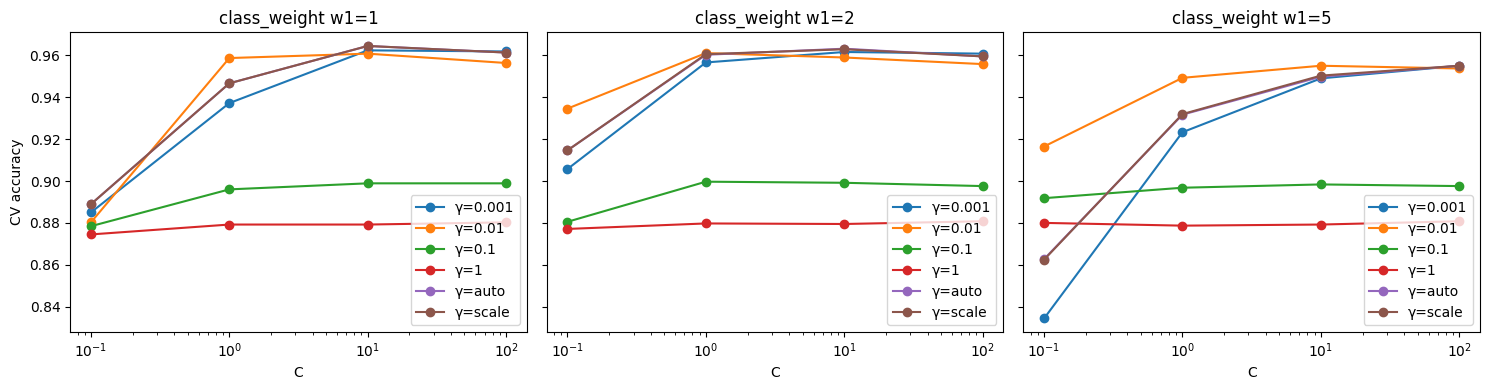

In [161]:
grid_search.fit(X_train_full, y_train)

# 4) Collect results
df = pd.DataFrame(grid_search.cv_results_)
# Create a readable label for each class_weight setting
df["cw_label"] = df["param_svc__class_weight"].apply(lambda cw: f"w1={cw[1]}")

# 5) Plot CV accuracy vs. C for each (gamma, class_weight) combination
unique_cw = df["cw_label"].unique()
fig, axes = plt.subplots(1, len(unique_cw), figsize=(5 * len(unique_cw), 4), sharey=True)

for ax, cw in zip(axes, unique_cw):
    sub = df[df["cw_label"] == cw]
    pivot = sub.pivot_table(
        index="param_svc__C",
        columns="param_svc__gamma",
        values="mean_test_score"
    )
    for gamma in pivot.columns:
        ax.plot(pivot.index.astype(float), pivot[gamma], marker='o', label=f"γ={gamma}")
    ax.set_xscale("log")
    ax.set_xlabel("C")
    ax.set_title(f"class_weight {cw}")
    if ax is axes[0]:
        ax.set_ylabel("CV accuracy")
    ax.legend(loc="lower right")

plt.tight_layout()
plt.show()


In [179]:
# put grid results into a DataFrame
df = pd.DataFrame(grid_search.cv_results_)

#  Compute the best mean CV score
best_score = df['mean_test_score'].max()
tol = 1e-3   # 0.001 = 0.1% tolerance

#  Keep only those runs within tol of best_score
close_enough = df[df['mean_test_score'] >= best_score - tol]

#  Convert C to float so we can compare
close_enough = close_enough.copy()
close_enough['param_svc__C'] = close_enough['param_svc__C'].astype(float)

# Pick the row with the smallest C as smaller C means less overfitting, more regularization
idx = close_enough['param_svc__C'].idxmin()
simple_model = close_enough.loc[idx, [
    'param_svc__C',
    'param_svc__gamma',
    'param_svc__class_weight',
    'mean_test_score'
]]

print("Best CV score:      ", best_score)
print("Tolerance (±0.1%):   ", best_score - tol, "–", best_score)
print("\nSimplest model within tol:")
print(simple_model)

Best CV score:       0.9645493393483502
Tolerance (±0.1%):    0.9635493393483502 – 0.9645493393483502

Simplest model within tol:
param_svc__C                       10.0
param_svc__gamma                  scale
param_svc__class_weight    {0: 1, 1: 1}
mean_test_score                0.964549
Name: 36, dtype: object


In [188]:
# save the best SVM model
svm_model.set_params(svc__C=10, svc__gamma="scale", svc__class_weight={0: 1, 1: 1})

best_svm = svm_model.fit(X_train_full, y_train)

# 3) Evaluate the best model on val & test
y_val_pred  = best_svm.predict(X_val_full)
print("SVM validation accuracy: ", accuracy_score(y_val, y_val_pred))
print("\nSVM validation report:")
print(classification_report(y_val, y_val_pred, digits=4))
print("SVM validation conf. matrix:")
print(confusion_matrix(y_val, y_val_pred))

SVM validation accuracy:  0.9684873949579832

SVM validation report:
              precision    recall  f1-score   support

           0     0.9751    0.9892    0.9821       833
           1     0.9159    0.8235    0.8673       119

    accuracy                         0.9685       952
   macro avg     0.9455    0.9064    0.9247       952
weighted avg     0.9677    0.9685    0.9678       952

SVM validation conf. matrix:
[[824   9]
 [ 21  98]]


# Test!

In [189]:
# 4) Test performance
y_test_pred = best_svm.predict(X_test_full)
print("\nSVM test accuracy:       ", accuracy_score(y_test, y_test_pred))
print("\nSVM test report:")
print(classification_report(y_test, y_test_pred, digits=4))
print("SVM test conf. matrix:")
print(confusion_matrix(y_test, y_test_pred))


SVM test accuracy:        0.979009235936188

SVM test report:
              precision    recall  f1-score   support

           0     0.9829    0.9933    0.9881      1042
           1     0.9493    0.8792    0.9129       149

    accuracy                         0.9790      1191
   macro avg     0.9661    0.9362    0.9505      1191
weighted avg     0.9787    0.9790    0.9787      1191

SVM test conf. matrix:
[[1035    7]
 [  18  131]]
